/tmp/ipykernel_24081/1581069670.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MicSigV1['Type'].loc[ind[0]] = "REGIONAL"
/tmp/ipykernel_24081/1581069670.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MicSigV1['Type'].loc[ind2[0]] = "LP"
/tmp/ipykernel_24081/1581069670.py:222: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MicSigV1['Type'].loc[ind3[0]] = "VT"
/home/reginald/miniconda3/envs/dva-earth-science/lib/python3.9/si

FileNotFoundError: [Errno 2] No such file or directory: './output/confusion_matrixD1_Max_Raw_kNN.png'

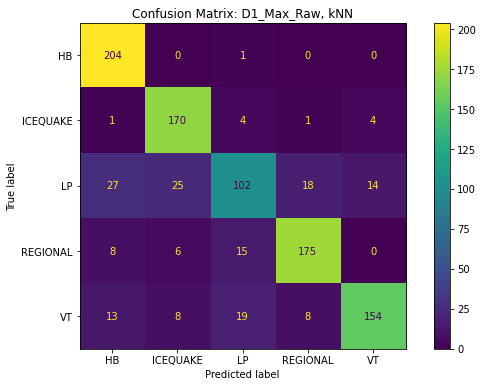

In [5]:
import os 

from imblearn.combine import SMOTETomek
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn import linear_model
from sklearn import metrics

OUTPUT_DIR = "./output"
def plot_confusion_matrix(key_list, col_name, model_name, X_test, y_test, model, pred):
    confusion_matrix(y_test, pred)
    # accuracy_score(y_test,optyts_knnpred ) #0.8487394957983193

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Confusion Matrix: ' + col_name + ", " + model_name)
    disp = metrics.plot_confusion_matrix(model, X_test, y_test, display_labels=key_list, ax=ax)
    disp.confusion_matrix

    plt.savefig(f"{OUTPUT_DIR}/confusion_matrix" + col_name + "_" + model_name + ".png")
    plt.clf()

def plot_precision_recall(MicSigV1, use_SMOTE = False):
    y = MicSigV1['Type_CatNbr']
    Y = label_binarize(y, classes=[0, 1, 2, 3, 4])
    n_classes = Y.shape[1]

    cols_X = ['D1_Max_Raw', 'D1_Max_2', 'D1_Max_4', 'D1_Max_6']
    for col in cols_X:
        X = MicSigV1[['E_Raw', col, 'Freq_Raw']]

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
        if use_SMOTE:
            smt = SMOTETomek(random_state=42)
            X_res, y_res = smt.fit_resample(X, Y)
            X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

        classifier = OneVsRestClassifier(make_pipeline(StandardScaler(), LinearSVC(random_state=42)))
        classifier.fit(X_train, y_train)
        y_score = classifier.decision_function(X_test)

        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
            average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
        average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")

        _, ax = plt.subplots(figsize=(7, 8))

        display = PrecisionRecallDisplay(
            recall=recall["micro"],
            precision=precision["micro"],
            average_precision=average_precision["micro"],
        )
        display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

        colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])
        for i, color in zip(range(n_classes), colors):
            display = PrecisionRecallDisplay(
                recall=recall[i],
                precision=precision[i],
                average_precision=average_precision[i],
            )
            display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

        # add the legend for the iso-f1 curves
        handles, labels = display.ax_.get_legend_handles_labels()
        #handles.extend([l])
        labels.extend(["iso-f1 curves"])

        # set the legend and the axes
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.legend(handles=handles, labels=labels, loc="best")
        if use_SMOTE:
            ax.set_title(col + ": Precision-Recall curve (with SMOTE)")
            plt.savefig(f"{OUTPUT_DIR}/precision_recall_" + col + "_SMOTE.png")
        else:
            ax.set_title(col + ": Precision-Recall curve (without SMOTE)")
            plt.savefig(f"{OUTPUT_DIR}/precision_recall_" + col + ".png")
        plt.clf()

def ResultsTemplate(MicSigV1):
    KeepCols = ['Year', 'Month', 'Type', 'Duration']
    template = MicSigV1.copy().loc[:, KeepCols]
    columns = ['Cleaning', 'KNN', 'SVM', 'RF', 'KMs', 'LR']
    template[columns] = None
    template.head()

    return template

def knn(key_list, col_name, X_train, X_test, y_train, y_test):
    # Knn Model
    no_neighbors = np.arange(2, 50, 5)
    accuracy_knn = np.zeros((no_neighbors.shape[0]))
    k = 0
    for knn in no_neighbors:
        knn_model = KNeighborsClassifier(n_neighbors=knn).fit(X_train, y_train)
        yts_knnpred = knn_model.predict(X_test)  # confusion_matrix(y_train, y_pred)
        accuracy_knn[k] = accuracy_score(y_test, yts_knnpred)
        k += 1
    opt_knn = no_neighbors[np.argmax(accuracy_knn)]
    optknn_model = KNeighborsClassifier(n_neighbors=opt_knn).fit(X_train, y_train)
    optyts_knnpred = knn_model.predict(X_test)

    plot_confusion_matrix(key_list, col_name, "kNN", X_test, y_test, optknn_model, optyts_knnpred)

    return knn_model

def svm(key_list, col_name, X_train, X_test, y_train, y_test):
    svm_model = SVC(gamma='auto', decision_function_shape='ovo').fit(X_train, y_train)
    yts_svm = svm_model.predict(X_test)

    plot_confusion_matrix(key_list, col_name, "SVM", X_test, y_test, svm_model, yts_svm)

    return svm_model

def random_forest(key_list, col_name, X_train, X_test, y_train, y_test):
    rf_model = RandomForestClassifier(n_estimators=1000, random_state=42).fit(X_train, y_train)
    yts_rf = rf_model.predict(X_test)

    plot_confusion_matrix(key_list, col_name, "Random Forest", X_test, y_test, rf_model, yts_rf)

    return rf_model

def kMeans(X, y):
    km_model = KMeans(n_clusters=5, random_state=42).fit_predict(X)
    confusion_matrix(y, km_model)
    accuracy_score(y, km_model)  # 0.2384161752316765

    return km_model

def logistic_regression(key_list, col_name, X_train, X_test, y_train, y_test):
    lr = linear_model.LogisticRegression(multi_class='multinomial', max_iter=1000).fit(X_train, y_train)
    yts_lr = lr.predict(X_test)
    accuracy_score(y_test, yts_lr)  # 0.8529411764705882

    plot_confusion_matrix(key_list, col_name, "Logistic Regression", X_test, y_test, lr, yts_lr)

    return lr

def generate_models(MicSigV1):
    label_encoder = LabelEncoder()
    MicSigV1['Type'] = MicSigV1['Type'].astype('str')
    MicSigV1['Type_CatNbr'] = label_encoder.fit_transform((MicSigV1['Type'].values))
    y = MicSigV1['Type_CatNbr']
    Type_Mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    key_list = [key for key in Type_Mapping.keys()]

    results_template = ResultsTemplate(MicSigV1)

    cols_X = ['D1_Max_Raw', 'D1_Max_2', 'D1_Max_4', 'D1_Max_6']
    results_list = []
    for col in cols_X:
        X = MicSigV1[['E_Raw', col, 'Freq_Raw']]

        # Classification Model - Normalized Raw Data
        # Split the data
        smt = SMOTETomek(random_state=42)
        X_res, y_res = smt.fit_resample(X, y)
        X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

        knn_model = knn(key_list, col, X_train, X_test, y_train, y_test)
        svm_model = svm(key_list, col, X_train, X_test, y_train, y_test)
        rf_model = random_forest(key_list, col, X_train, X_test, y_train, y_test)
        km_model = kMeans(X, y)
        lr = logistic_regression(key_list, col, X_train, X_test, y_train, y_test)

        results_df = results_template.copy()
        results_df['Cleaning'] = 'Raw'
        results_df['KNN'] = knn_model.predict(X)
        results_df['SVM'] = svm_model.predict(X)
        results_df['RF'] = rf_model.predict(X)
        results_df['KMs'] = km_model
        results_df['LR'] = lr.predict(X)
        id_vars = ['Year', 'Month', 'Type', 'Duration', 'Cleaning']

        # Cast data into long form
        results_df = pd.melt(results_df, id_vars=id_vars, var_name='Model', value_name='Prediction')

        # Convert encoded labels to strings
        results_df.Prediction = results_df.Prediction.apply(lambda x: label_encoder.inverse_transform([x])[0])

        results_list.append(results_df)

    Output = pd.concat(results_list)
    Output = Output.reset_index()
    Output = Output.rename(columns={'index': 'EQ'})
    Output.to_csv('./Visualization/classification_results.csv', index=False)

    plot_precision_recall(MicSigV1) # No SMOTE
    plot_precision_recall(MicSigV1, True) # With SMOTE

def main():
    input_file = './clean_data.parquet'
    MicSigV1 = pd.read_parquet(input_file)

    #generate output dir
    if not os.path.exists(OUTPUT_DIR):
        os.mkdir(OUTPUT_DIR)

    # Cleaning data
    ind = np.where(MicSigV1['Type'] == '''['REGIONAL']''')
    ind2 = np.where(MicSigV1['Type'] == '''['LP']''')
    ind3 = np.where(MicSigV1['Type'] == '''VT ''')
    MicSigV1['Type'].loc[ind[0]] = "REGIONAL"
    MicSigV1['Type'].loc[ind2[0]] = "LP"
    MicSigV1['Type'].loc[ind3[0]] = "VT"

    generate_models(MicSigV1)

if __name__ == "__main__":
    main()
